# Minimum Wage Example Notebook with DiD

This notebook implements Difference-in-Differences in an application on
the effect of minimum wage changes on teen employment. We use data from
[Callaway
(2022)](https://bcallaway11.github.io/files/Callaway-Chapter-2022/main.pdf). The data are annual county level data from the United States covering 2001 to 2007. The outcome variable is log county-level teen employment, and the treatment variable is an indicator for whether the county has a minimum wage above the federal minimum wage. Note that this definition of the treatment variable makes the analysis straightforward but ignores the nuances of the exact value of the minimum wage in each county and how far those values are from the federal minimum. The data also include county population and county average annual pay.
See [Callaway and Sant’Anna
(2021)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620303948)
for additional details on the data.

First, we will load some libraries.

In [ ]:
!pip install doubleml

In [ ]:
!pip install formulaic

In [ ]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline
import patsy
import warnings

warnings.filterwarnings("ignore")
np.random.seed(772023)

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from formulaic import Formula

class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula):
        self.formula = formula

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        return df.values.astype(np.float64)

## Loading the data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv", index_col=0)

In [ ]:
data.head()

,countyreal,state_name,year,FIPS,emp0A01_BS,quarter,censusdiv,pop,annual_avg_pay,state_mw,fed_mw,treated,G,lemp,lpop,lavg_pay,region,ever_treated,id
1,2013,Alaska,2001,2013,15,1,9,2459,22155,5.65,5.15,1,2001,2.708050,7.807510,10.005818,4,1,2013
2,2013,Alaska,2002,2013,17,1,9,2664,28447,5.65,5.15,1,2001,2.833213,7.887584,10.255798,4,1,2013
3,2013,Alaska,2003,2013,12,1,9,2715,30184,7.15,5.15,1,2001,2.484907,7.906547,10.315067,4,1,2013
4,2013,Alaska,2004,2013,13,1,9,2677,27557,7.15,5.15,1,2001,2.564949,7.892452,10.224012,4,1,2013
5,2013,Alaska,2005,2013,11,1,9,2646,30396,7.15,5.15,1,2001,2.397895,7.880804,10.322066,4,1,2013


### Data Preparation

We remove observations that are already treated in the first observed period (2001). We drop all variables that we won't use in our analysis.

In [ ]:
data = data.loc[(data.G==0) | (data.G>2001)]
data.drop(columns=["countyreal","state_name","FIPS","emp0A01_BS",
                   "quarter", "censusdiv","pop","annual_avg_pay",
                   "state_mw","fed_mw", "ever_treated"], inplace=True)

Next, we create the treatment groups. We focus our analysis exclusively on the set of counties that had wage increases away from the federal minimum wage in 2004. That is, we treat 2003 and earlier as the pre-treatment period.

In [ ]:
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007]
treat, cont = {}, {}
for year in years:
    treat[year] = data.loc[(data.G == 2004) & (data.year == year)].copy()
    cont[year] = data.loc[((data.G == 0) | (data.G > year)) & (data.year == year)].copy()

We assume that the basic assumptions, particularly parallel trends, hold after conditioning on pre-treatment variables: 2001 population, 2001 average pay and 2001 teen employment, as well as the region in which the county is located. (The region is characterized by four
categories.)

Consequently, we want to extract the control variables for both treatment and control group in 2001.

In [ ]:
treat[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)
cont[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)

2003 serves as the pre-treatment period for both counties that do receive the treatment in 2004 and those that do not.

In [ ]:
treatB = pd.merge(treat[2003], treat[2001], on = "id", suffixes = ["_pre", "_0"])
treatB.drop(columns = ["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace= True)

contB = pd.merge(cont[2003], cont[2001], on = "id", suffixes = ["_pre","_0"])
contB.drop(columns = ["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace= True)

We estimate the ATET in 2004-2007, which corresponds to the effect in the year of treatment as well as in the three years after the treatment. The control observations are the observations that still have the federal minimum wage in each year. (The control group is shrinking in each year as additional units receive treatment).

In [ ]:
tdid, cdid = {}, {}
did_data = {}
# the first year will be used for pre-trend testing later on
for year in [2002, 2004, 2005, 2006, 2007]:
    treat[year].drop(columns=["lpop","lavg_pay","year","G","region"], inplace=True)
    cont[year].drop(columns=["lpop","lavg_pay","year","G","region"], inplace=True)

    tdid[year] = pd.merge(treat[year], treatB, on = "id")
    tdid[year]["dy"] = tdid[year]["lemp"] - tdid[year]["lemp_pre"]
    tdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)
    tdid[year].treated = 1 # forcing treatment to be 1, so that 2002 is "treated" when testing pre-trends

    cdid[year] = pd.merge(cont[year], contB, on = "id")
    cdid[year]["dy"] = cdid[year]["lemp"] - cdid[year]["lemp_pre"]
    cdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)

    # join control and treatment data and create one-hot-encoded region variables
    did_data[year] = pd.concat((tdid[year], cdid[year]))
    dummy_data = pd.get_dummies(did_data[year].region, drop_first=True, prefix="region")
    did_data[year] = pd.concat((did_data[year], dummy_data), axis=1).drop(columns=["region"])

In [ ]:
did_data[2004].head()

,treated,lemp_0,lpop_0,lavg_pay_0,dy,region_2,region_3,region_4
0,1,5.117994,9.776676,10.219356,-0.118482,1,0,0
1,1,6.302619,10.677615,10.505150,0.065813,1,0,0
2,1,7.334329,11.127204,10.162423,0.008202,1,0,0
3,1,3.737670,9.156940,10.283908,-0.336472,1,0,0
4,1,3.970292,8.529912,9.837935,0.125163,1,0,0


### Estimation of the ATET with DML

We estimate the ATET of the county level minimum wage being larger than the federal minimum with the DML algorithm presented in Section 16.3 in the book. This requires estimation of the nuisance functions $E[Y|D=0,X]$, $E[D|X]$ as well as $P(D = 1)$. For the conditional expectation functions, we will consider different modern ML regression methods, namely: Constant (= no controls); a linear combination of the controls; an expansion of the raw control variables including all third order interactions; Lasso (CV); Ridge (CV); Random Forest.
The methods indicated with CV have their tuning parameter selected by cross-validation.


The following code block implements the DML estimator with cross-fitting

In [ ]:
def final_stage(D, y, Dhat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = ((D - Dhat) / (phat * (1 - Dhat))) * (y - yhat)
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr

def dr_att(X, D, y, modely, modeld, *, trimming=0.01, nfolds=5):
    '''
    DML for the ATT estimation (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls, pandas DataFrame
    D: treatment indicator, numpy array
    y: the outcome (the delta before and after intervention in DiD), numpy array
    modely: the ML model for predicting y (the delta Y_1 - Y_0 in DiD)
    modeld: the ML model for predicting the treatment D
    trimming: threshold below which to trim propensities, float (default=0.01)
    nfolds: the number of folds in cross-fitting, int (default=5)

    Output
    ------
    point: the point estimate of the treatment on the treated
    stderr: the standard error of the treatment effect
    yhat: cross-fitted predictions of the outcome y under control, E[y|D=0, X]
    Dhat: cross-fitted predictions of the treatment D, E[D|X]
    rmsey: the RMSE of the model y ~ X | D==0
    rmseD: the RMSE of the model D ~ X
    phat: the estimated treatment probability in each fold
    '''
    cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    for train, test in cv.split(X, D):
        modely.fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
        yhat[test] = modely.predict(X.iloc[test])
    # fit a model P[D]
    phat = cross_val_predict(DummyRegressor(), X, D, cv=cv)
    # propensity scores E[D | X]
    Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba')[:, 1]
    # trimm propensity score
    Dhat = np.clip(Dhat, trimming, 1 - trimming)
    # estimation of parameter
    point, stderr = final_stage(D, y, Dhat, yhat, phat)
    # nuisance function rmse's
    rmsey = np.sqrt(np.mean((y - yhat)[D==0]**2))
    rmseD = np.sqrt(np.mean((D - Dhat)**2))
    return point, stderr, yhat, Dhat, rmsey, rmseD, phat

In [ ]:
def get_nuisance_learners(region_names):
    ''' Constructs the learners we will consider for nuisance estimation

    region_names: the available region names

    Returns: a dictionary of learners of the form {key: (ml_g, ml_m)}
    '''
    # a formula that will be used within a featurizer to create interactions
    # (region id) * (baseline outcome) + (region id) + (baseline outcomes)
    formula = '0 + ' + ' + '.join([f"{col} * (lemp_0 + lpop_0 + lavg_pay_0)" for col in region_names])
    # a generic polynomial featurizer
    poly = lambda: PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    learners = {
        # no X
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        # linear models of X
        "Basic": (LinearRegression(), LogisticRegression(random_state=123)),
        # linear models with region interactions
        "Expansion": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                      make_pipeline(FormulaTransformer(formula), LogisticRegression(random_state=123))),
        # full blown third degree interactions of X, with Lasso
        "Lasso (CV)": (make_pipeline(poly(), LassoCV(n_jobs=-1, random_state=123)),
                       make_pipeline(poly(), LogisticRegressionCV(penalty="l1", solver="liblinear", n_jobs=-1, random_state=123))),
        # full blown third degree interactions, with Ridge
        "Ridge (CV)": (make_pipeline(poly(), RidgeCV()),
                       make_pipeline(poly(), LogisticRegressionCV(n_jobs=-1, random_state=123))),
        # Random Forest regressors and classifiers
        "Random Forest": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
                          RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123))
    }
    return learners

In [ ]:
def MinWageDiD(years):
    # arrays for saving the results
    att, se_att, RMSE_d, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RMSE_d[year], RMSE_y[year] = {}, {}, {}, {}

        # set up the data for the specific year
        X = did_data[year].drop(columns=["treated", "dy"]) # controls
        D = did_data[year].treated.values # treatment
        dy = did_data[year].dy.values # delta outcome betwee post and pre treatment
        region_names = [col for col in X.columns if col.startswith('region_')]

        # get dictionary of nuisance learners
        learners = get_nuisance_learners(region_names)

        # for storing the nuisance predictions
        pred_y, pred_d = {}, {}
        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            point, stderr, dyhat, Dhat, rmsey, rmsed, phat = dr_att(X, D, dy, ml_g, ml_m, trimming=0.01, nfolds=5)
            pred_y[method], pred_d[method] = dyhat, Dhat
            att[year][method], se_att[year][method] = point, stderr
            RMSE_y[year][method], RMSE_d[year][method] = rmsey, rmsed

        # find best model for dy and d and use predictions
        besty = min(RMSE_y[year], key=RMSE_y[year].get)
        bestd = min(RMSE_d[year], key=RMSE_d[year].get)
        # phat this is the same for all methods and equal to the cross-fitted Pr[D=1]
        point, stderr = final_stage(D, dy, pred_d[bestd], pred_y[besty], phat)
        att[year]["Best"], se_att[year]["Best"] = point, stderr
        RMSE_y[year]["Best"] = RMSE_y[year][besty]
        RMSE_d[year]["Best"] = RMSE_d[year][bestd]

        # we can also find the best linear combination of models via stacking
        pred_y = pd.DataFrame(pred_y)
        pred_d = pd.DataFrame(pred_d)
        stacked_pred_y = LinearRegression().fit(pred_y, dy).predict(pred_y)
        stacked_pred_d = LinearRegression().fit(pred_d, D).predict(pred_d)
        # phat this is the same for all methods and equal to the cross-fitted Pr[D=1]
        point, stderr = final_stage(D, dy, stacked_pred_d, stacked_pred_y, phat)
        att[year]["Stack"], se_att[year]["Stack"] = point, stderr
        RMSE_y[year]["Stack"] = np.sqrt(np.mean((dy - stacked_pred_y)[D==0]**2))
        RMSE_d[year]["Stack"] = np.sqrt(np.mean((D - stacked_pred_d)**2))

    return att, se_att, RMSE_y, RMSE_d

att, se_att, RMSE_y, RMSE_d = MinWageDiD([2004, 2005, 2006, 2007])

Estimating ATET for year 2004. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2005. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2006. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2007. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.


We start by reporting the RMSE obtained during cross-fitting for each learner in each period.

In [ ]:
table1 = pd.concat({'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
table1

2004                2005                2006            \
                 RMSE D   RMSE dy    RMSE D   RMSE dy    RMSE D   RMSE dy   
No Controls    0.198170  0.163240  0.200574  0.188136  0.211096  0.223408   
Basic          0.190027  0.163042  0.192400  0.185159  0.201089  0.217356   
Expansion      0.190152  0.163512  0.192613  0.185682  0.201322  0.218003   
Lasso (CV)     0.209429  0.163056  0.208909  0.185028  0.224792  0.217116   
Ridge (CV)     0.191414  0.162890  0.193718  0.185087  0.201915  0.217875   
Random Forest  0.190325  0.165177  0.192857  0.187938  0.200679  0.220051   
Best           0.190027  0.162890  0.192400  0.185028  0.200679  0.217116   
Stack          0.189106  0.162180  0.191430  0.184427  0.199550  0.216870   

                   2007            
                 RMSE D   RMSE dy  
No Controls    0.250283  0.230234  
Basic          0.220804  0.221772  
Expansion      0.219534  0.221867  
Lasso (CV)     0.273589  0.221615  
Ridge (CV)     0.229726  0.221764  
Random Forest  0.224474  0.222787  
Best           0.219534  0.221615  
Stack          0.216736  0.221134

It appears there is some signal in the regressors, as all methods outside of  LassoCV produce somewhat smaller RMSEs than the No Controls baseline. While it would be hard to reliably conclude which of the relatively good performing methods is statistically best here, Best (or a different ensemble) provides a good baseline that is principled in the sense that one could pre-commit to using the best learners without having first looked at the subsequent estimation results.

We report estimates of the ATET in each period in the following table, together with the aforementioned RMSE's.

In [ ]:
table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
table2

2004                                    2005            \
                 RMSE D   RMSE dy       att        se    RMSE D   RMSE dy   
No Controls    0.198170  0.163240 -0.040018  0.019055  0.200574  0.188136   
Basic          0.190027  0.163042 -0.021238  0.020711  0.192400  0.185159   
Expansion      0.190152  0.163512 -0.016967  0.023252  0.192613  0.185682   
Lasso (CV)     0.209429  0.163056 -0.038656  0.025408  0.208909  0.185028   
Ridge (CV)     0.191414  0.162890 -0.023332  0.019442  0.193718  0.185087   
Random Forest  0.190325  0.165177 -0.023025  0.019238  0.192857  0.187938   
Best           0.190027  0.162890 -0.018586  0.021218  0.192400  0.185028   
Stack          0.189106  0.162180 -0.021560  0.020335  0.191430  0.184427   

                                       2006                                \
                    att        se    RMSE D   RMSE dy       att        se   
No Controls   -0.076277  0.020163  0.211096  0.223408 -0.116778  0.019763   
Basic         -0.047466  0.020917  0.201089  0.217356 -0.052880  0.019828   
Expansion     -0.049430  0.021861  0.201322  0.218003 -0.052125  0.020505   
Lasso (CV)    -0.035780  0.025411  0.224792  0.217116 -0.043345  0.029495   
Ridge (CV)    -0.045164  0.020043  0.201915  0.217875 -0.050684  0.019897   
Random Forest -0.049165  0.020301  0.200679  0.220051 -0.050563  0.020030   
Best          -0.048474  0.021021  0.200679  0.217116 -0.048563  0.020316   
Stack         -0.048533  0.020782  0.199550  0.216870 -0.049789  0.019970   

                   2007                                
                 RMSE D   RMSE dy       att        se  
No Controls    0.250283  0.230234 -0.131077  0.022604  
Basic          0.220804  0.221772 -0.066978  0.023567  
Expansion      0.219534  0.221867 -0.070840  0.025843  
Lasso (CV)     0.273589  0.221615 -0.061821  0.030990  
Ridge (CV)     0.229726  0.221764 -0.063971  0.022798  
Random Forest  0.224474  0.222787 -0.067078  0.023048  
Best           0.219534  0.221615 -0.076803  0.027319  
Stack          0.216736  0.221134 -0.064939  0.024947

Here, we see that most methods provide point estimates that suggest the effect of the minimum wage increase leads to decreases in youth employment with small effects in the initial period that become larger in the years following the treatment. This pattern seems economically plausible as it may take time for firms to adjust employment and other input choices in response to a minimum wage change. In the estimates that are reported in the book we have values that are not consistent with this pattern, however, they systematically underperform in terms of having poor cross-fit prediction performance. In terms of point estimates, the other pattern that emerges is that all estimates that use the covariates produce ATET estimates that are systematically smaller in magnitude than the No Controls baseline, suggesting that failing to include the controls may lead to overstatement of treatment effects in this example.

Turning to inference, we would reject the hypothesis of no minimum wage effect two or more years after the change at the 5% level, even after multiple testing correction, if we were to focus on many of the estimators.

### Assess pre-trends

Because we have data for the period 2001-2007, we can perform a so-called pre-trends test to provide some evidence about the plausibility of the conditional parallel trends assumption. Specifically, we can continue to use 2003 as the reference period but now consider 2002 to be the treatment period. Sensible economic mechanisms underlying the assumption would then typically suggest that the ATET in 2002 - before the 2004 minimum wage change we are considering - should be zero. Finding evidence that the ATET in 2002 is non-zero then calls into question the validity of the assumption.

We change the treatment status of those observations, which received treatment in 2004 in the 2002 data and create a placebo treatment as well as control group. We call the same estimation pipeline that we used to obtain our ATET estimates for 2004-2007. We now hope that we get a statistical null result.

In [ ]:
att, se_att, RMSE_y, RMSE_d = MinWageDiD([2002])

Estimating ATET for year 2002. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.


In [ ]:
table2002 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2002 = table2002.swaplevel(0, 1, axis=1)
table2002 = table2002.sort_index(axis=1)
table2002

2002                              
                 RMSE D   RMSE dy       att        se
Basic          0.187976  0.154111  0.002841  0.014206
Best           0.187976  0.154111  0.002841  0.014206
Expansion      0.188302  0.154192  0.003926  0.014553
Lasso (CV)     0.206890  0.154542  0.009917  0.021796
No Controls    0.194396  0.154471 -0.004753  0.013299
Random Forest  0.191169  0.154875  0.001522  0.013041
Ridge (CV)     0.188720  0.154331  0.002254  0.013148
Stack          0.187624  0.153370  0.002241  0.013333

Here we see broad agreement across all methods in the sense of returning point estimates that are small in magnitude and small relative to standard errors. In no case would we reject the hypothesis that the pre-event effect in 2002 is different from zero at usual levels of significance. We note that failing to reject the hypothesis of no pre-event effects certainly does not imply that the conditional DiD assumption is in fact satisfied. For example, confidence intervals include values that would be consistent with relatively large pre-event effects. However, it is reassuring to see that there is not strong evidence of a violation of the underlying identifying assumption.

### Visualizing the Effect of Treatment in 2004 Over the Years

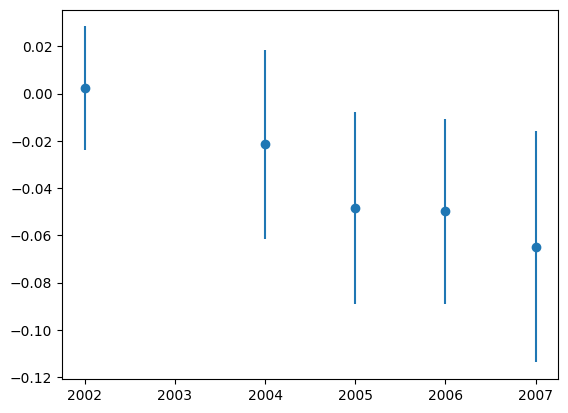

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
table_all = pd.concat([table2002, table2], axis=1)
years = [2002, 2004, 2005, 2006, 2007]
plt.errorbar(years, np.array([table_all[year]['att'].loc['Stack'] for year in years]),
             yerr=1.96*np.array([table_all[year]['se'].loc['Stack'] for year in years]), fmt='o')
plt.show()

### Repication with `DoubleML`
The high-level implementation `DoubleML` can be used to replicate the above. Please note, that it will run for a while (around 15min).

In [ ]:
def MinWageDiDwithDoubleML(years):
    # arrays for saving the results
    att, se_att, RMSE_d, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RMSE_d[year], RMSE_y[year] = {}, {}, {}, {}

        # set up the data for the specific year
        region_names = [col for col in did_data[year].columns if col.startswith("region_")]
        dml_data = dml.DoubleMLData(data = did_data[year],
                                    x_cols=["lemp_0", "lpop_0", "lavg_pay_0"] + region_names,
                                    y_col="dy",
                                    d_cols="treated")

        # get dictionary of nuisance learners
        learners = get_nuisance_learners(region_names)

        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            if method == "Expansion":
                # we can't use the FormulaTransformer pipeline with DoubleML because it strips internally the pandas metadata
                # so we have to explicitly transform the data before passing to DoubleML
                trans_dml_data =  dml.DoubleMLData.from_arrays(x=ml_g[0].fit_transform(did_data[year]),
                                                               y=did_data[year].dy.values,
                                                               d=did_data[year].treated.values)
                dml_obj = dml.DoubleMLDID(trans_dml_data, ml_g=ml_g[1], ml_m=ml_m[1],
                                          in_sample_normalization=False, trimming_threshold=0.01)
            else:
                dml_obj = dml.DoubleMLDID(dml_data, ml_g=ml_g, ml_m=ml_m,
                                          in_sample_normalization=False, trimming_threshold=0.01)
            # The following two lines are only needed to exactly replicate the custom
            # implementation results, so that the same k-folds are used in cross-fitting
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
            dml_obj.set_sample_splitting(list(cv.split(did_data[year][dml_data.x_cols], did_data[year].treated.values)))
            dml_obj.fit()
            att[year][method] = dml_obj._coef[0]
            se_att[year][method] = dml_obj._se[0]
            RMSE_y[year][method] = np.mean(dml_obj.rmses["ml_g0"])
            RMSE_d[year][method] = np.mean(dml_obj.rmses["ml_m"])

    return att, se_att, RMSE_y, RMSE_d

In [ ]:
att, se_att, RMSE_y, RMSE_d = MinWageDiDwithDoubleML([2004, 2005])

Estimating ATET for year 2004. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2005. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.


In [ ]:
tabledml = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
tabledml = tabledml.swaplevel(0, 1, axis=1)
tabledml = tabledml.sort_index(axis=1)
tabledml

2004                                    2005            \
                 RMSE D   RMSE dy       att        se    RMSE D   RMSE dy   
No Controls    0.198170  0.163240 -0.040018  0.019055  0.200574  0.188136   
Basic          0.190027  0.163042 -0.021238  0.020711  0.192400  0.185159   
Expansion      0.190152  0.163512 -0.016967  0.023252  0.192613  0.185682   
Lasso (CV)     0.209429  0.163056 -0.038656  0.025408  0.208909  0.185028   
Ridge (CV)     0.191414  0.162890 -0.023332  0.019442  0.193718  0.185087   
Random Forest  0.190325  0.165177 -0.023025  0.019238  0.192857  0.187938   

                                   
                    att        se  
No Controls   -0.076277  0.020163  
Basic         -0.047466  0.020917  
Expansion     -0.049430  0.021861  
Lasso (CV)    -0.035780  0.025411  
Ridge (CV)    -0.045164  0.020043  
Random Forest -0.049165  0.020301

We find that the DoubleML package returns basically the same results as the custom implementation (presented below for comparison), modulo the small randomness due to the random sample splitting involved in the cross-fitting process.

In [ ]:
table2

2004                                    2005            \
                 RMSE D   RMSE dy       att        se    RMSE D   RMSE dy   
No Controls    0.198170  0.163240 -0.040018  0.019055  0.200574  0.188136   
Basic          0.190027  0.163042 -0.021238  0.020711  0.192400  0.185159   
Expansion      0.190152  0.163512 -0.016967  0.023252  0.192613  0.185682   
Lasso (CV)     0.209429  0.163056 -0.038656  0.025408  0.208909  0.185028   
Ridge (CV)     0.191414  0.162890 -0.023332  0.019442  0.193718  0.185087   
Random Forest  0.190325  0.165177 -0.023025  0.019238  0.192857  0.187938   
Best           0.190027  0.162890 -0.018586  0.021218  0.192400  0.185028   
Stack          0.189106  0.162180 -0.021560  0.020335  0.191430  0.184427   

                                       2006                                \
                    att        se    RMSE D   RMSE dy       att        se   
No Controls   -0.076277  0.020163  0.211096  0.223408 -0.116778  0.019763   
Basic         -0.047466  0.020917  0.201089  0.217356 -0.052880  0.019828   
Expansion     -0.049430  0.021861  0.201322  0.218003 -0.052125  0.020505   
Lasso (CV)    -0.035780  0.025411  0.224792  0.217116 -0.043345  0.029495   
Ridge (CV)    -0.045164  0.020043  0.201915  0.217875 -0.050684  0.019897   
Random Forest -0.049165  0.020301  0.200679  0.220051 -0.050563  0.020030   
Best          -0.048474  0.021021  0.200679  0.217116 -0.048563  0.020316   
Stack         -0.048533  0.020782  0.199550  0.216870 -0.049789  0.019970   

                   2007                                
                 RMSE D   RMSE dy       att        se  
No Controls    0.250283  0.230234 -0.131077  0.022604  
Basic          0.220804  0.221772 -0.066978  0.023567  
Expansion      0.219534  0.221867 -0.070840  0.025843  
Lasso (CV)     0.273589  0.221615 -0.061821  0.030990  
Ridge (CV)     0.229726  0.221764 -0.063971  0.022798  
Random Forest  0.224474  0.222787 -0.067078  0.023048  
Best           0.219534  0.221615 -0.076803  0.027319  
Stack          0.216736  0.221134 -0.064939  0.024947